In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.13.0', '1.23.5')

In [ ]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
ROOT = './drive/MyDrive/CroppedFaces'

In [ ]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [ ]:
encoder = get_encoder((128, 128, 3))
encoder.load_weights("/content/drive/MyDrive/encoder_celeb_custom.h5")

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, files[i])
                positive = (folder, files[j])

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = os.listdir(os.path.join(directory, neg_folder))[random.randint(0, folder_list[neg_folder]-1)]
                negative = (neg_folder, neg_file)

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

In [ ]:
test_list = {}

directory = ROOT
folders = os.listdir(directory)
random.shuffle(folders)

# Creating Test-list
for folder in folders[:int(len(folders)*0.1)]:
    num_files = len(os.listdir(os.path.join(directory, folder)))
    test_list[folder] = num_files


test_triplet = create_triplets(directory, test_list)

In [ ]:
print(len(test_triplet))

990


In [ ]:
def get_siamese_distance(face_list1, face_list2):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    # prediction = np.where(distance<=threshold, 0, 1)
    return distance

def ModelMetrics(true, pred):
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Different', 'False Similar','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, get_siamese_distance(a, p))
    neg_list = np.append(neg_list, get_siamese_distance(a, n))

7/7 [==============================] - 0s 36ms/step



Accuracy of model: 0.8449494949494949



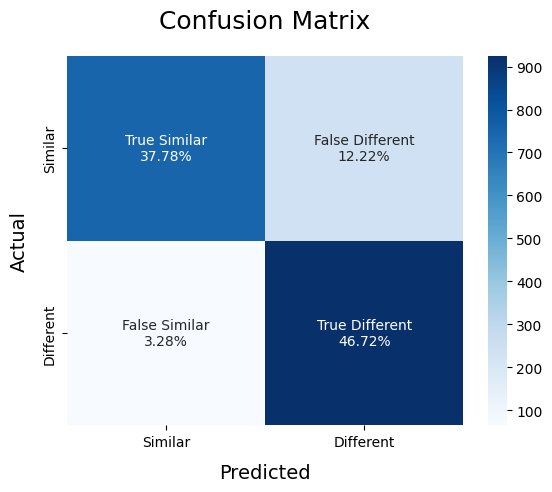

In [ ]:
y_true = np.array([0]*len(pos_list) + [1]*len(neg_list))
y_score = np.hstack([pos_list,neg_list])
y_pred = y_score > 1
ModelMetrics(y_true, y_pred)

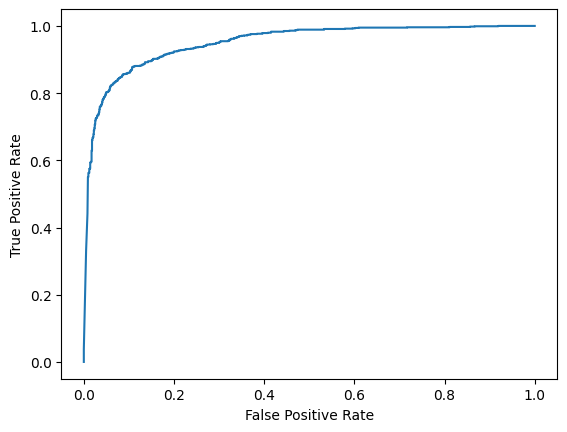

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_true, y_score)
RocCurveDisplay(fpr= fpr, tpr = tpr).plot()